In [1]:
import shutil, os
import glob
import numpy as np
import cv2
import scipy.io

import matplotlib.pyplot as plt

import torch
from torchvision import transforms
from torch.utils.data import DataLoader

In [2]:
from modules.helpers import *

In [3]:
data_dir = '/Users/ramith/Documents/170221T/FYP/data/20211129_qpm_Ahluwalia-lab_bacteria/'

In [4]:
files = ['160320/Phi_Acinetobacter.mat', '160320/Phi_B_subtilis.mat',
           '160320/Phi_Ecoli.mat', '160320/Phi_S_aureus.mat',
         
           '161020/Phi_01.mat', '161020/Phi_02.mat', '161020/Phi_03.mat',
           '161020/Phi_04.mat', '161020/Phi_05.mat', '161020/Phi_06.mat',
           '161020/Phi_07.mat', '161020/Phi_08.mat', '161020/Phi_09.mat',
           '161020/Phi_10.mat', '161020/Phi_11.mat', '161020/Phi_12_1.mat', '161020/Phi_12_2.mat',
            
           '280521/Phi_01_1.mat', '280521/Phi_01_2.mat', '280521/Phi_04.mat',
           '280521/Phi_05.mat', '280521/Phi_07.mat', '280521/Phi_11.mat']

In [5]:
print(len(files))

23


In [6]:
dataset = getDataset(data_dir,files[0])


160320/Phi_Acinetobacter.mat ************** 17162 loaded!


In [7]:
def draw_contour(idx, th):
    img = dataset[idx]/ np.max(dataset[idx])*255
    img = np.asarray(img, dtype=np.uint8)
    ret, thresh = cv2.threshold(img, th, 255, 0)
    
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    img_ = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    
    cv2.drawContours(img_, contours, -1, (255,0,0),1)
    
    # create hull array for convex hull points
    hull = []

    # calculate points for each contour
    for i in range(len(contours)):
        # creating convex hull object for each contour
        hull.append(cv2.convexHull(contours[i], False))
        
        
    # create an empty black image
    drawing = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

    # draw contours and hull points
    area = []
    for i in range(len(contours)):
        c_area = cv2.contourArea(contours[i])
        h_area = cv2.contourArea(hull[i])
        
#         print(" : C_Area = ", c_area, " Hull_Area ", h_area,end=" - ")
        
        if(h_area!=0 and (h_area - c_area)!=0):
            area.append((c_area/h_area)/ (h_area - c_area)*100)
        
    area = np.mean(area)     
#     print(area)
    
    
    if(is_bad_bacteria(len(contours),area)):
        color_contours = (255,182,193) # pink
        color          = (255, 0, 0)  # red
    else:
        color_contours = (0,255,0) # pink
        color          = (0,255, 0)  # red
        
    
    for i in range(len(contours)):
        # draw ith contour
        cv2.drawContours(drawing, contours, i, color_contours, 1, 8, hierarchy)
        
        # draw ith convex hull object
        cv2.drawContours(drawing, hull, i, color, 1, 8)
    
    return drawing, len(contours), round(area,2)

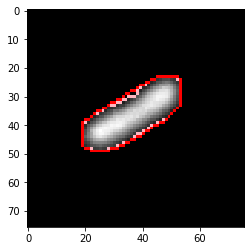

In [8]:
l = draw_contour(130,5)
plt.imshow(l[0])

In [9]:
def countIgnoredBacteria(th, multiple_count):
    img_lis = []
    contour_count = []
    ignored_bacteria = []

    for i in range(0,len(dataset)):
        ignore = False

        img, n_c, a_c = draw_contour(i,th)
        
        # Extract ignored bacteria images
        if is_bad_bacteria(n_c, a_c):
            ignore = True
            ignored_bacteria.append(img)
            label = "X ("
        else:
            label = "✓ (" 
            

        label += str(n_c) + ", " + str(a_c) + ")"
        img_lis.append(img)
        contour_count.append(label)
        
    ratio = len(ignored_bacteria)/len(dataset)
    
    print("Total Bacteria = ", len(dataset))
    print("Ignored Count  = ", len(ignored_bacteria))
    print("  -- multiple  = ", multiple_count)
    print("Proportion Removed = ",ratio )
    
    return img_lis, contour_count, ignored_bacteria

In [10]:
def BacteriaDistribution(th):
    img_lis = []
    contour_counts = []
    scores = []

    for i in range(0,len(dataset)):

        img, n_c, a_c = draw_contour(i,th)
        
        img_lis.append(img)
        contour_counts.append(n_c)
        scores.append(a_c)

    return img_lis, contour_counts, scores

In [11]:
img_lis, contour_counts, scores = BacteriaDistribution(5)

/Users/ramith/Documents/170221T/Semester 4/EN2550 - Image Processing/img-processing-env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/ramith/Documents/170221T/Semester 4/EN2550 - Image Processing/img-processing-env/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


## images with multiple bacteria $contour\_count > 1$

In [12]:
multiple_bac_images = []
multiple_bac_labels = []
for i in range(len(img_lis)):
    if(contour_counts[i]>1):
        multiple_bac_images.append(img_lis[i])
        multiple_bac_labels.append(contour_counts[i])
               


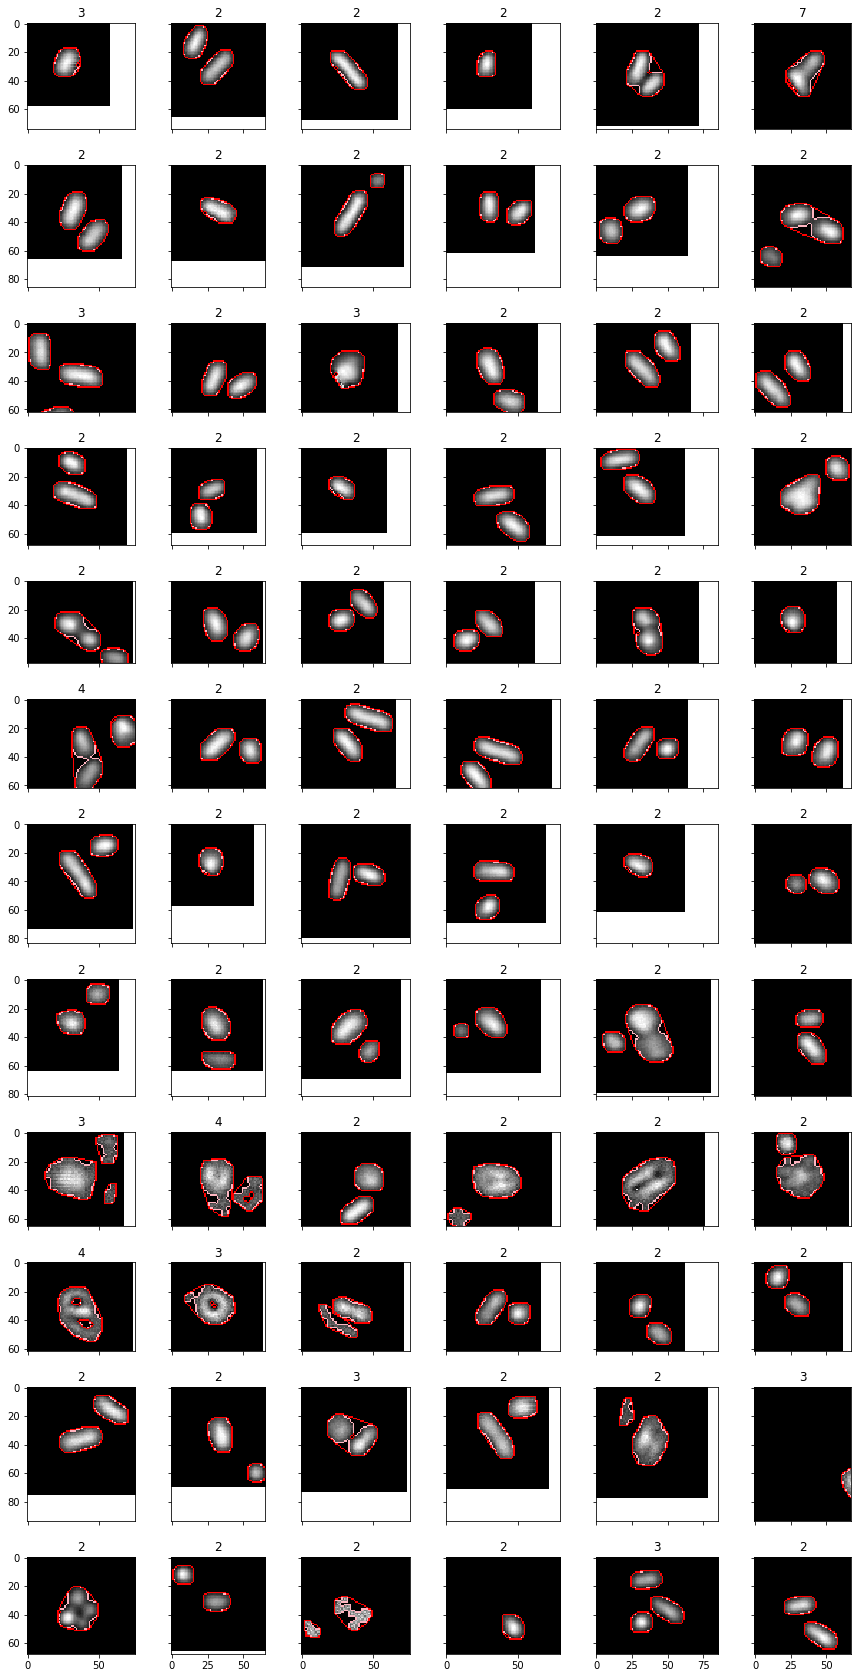

In [13]:
plot_image_set(multiple_bac_images,multiple_bac_labels)

## images with    - $3 < score < 6$

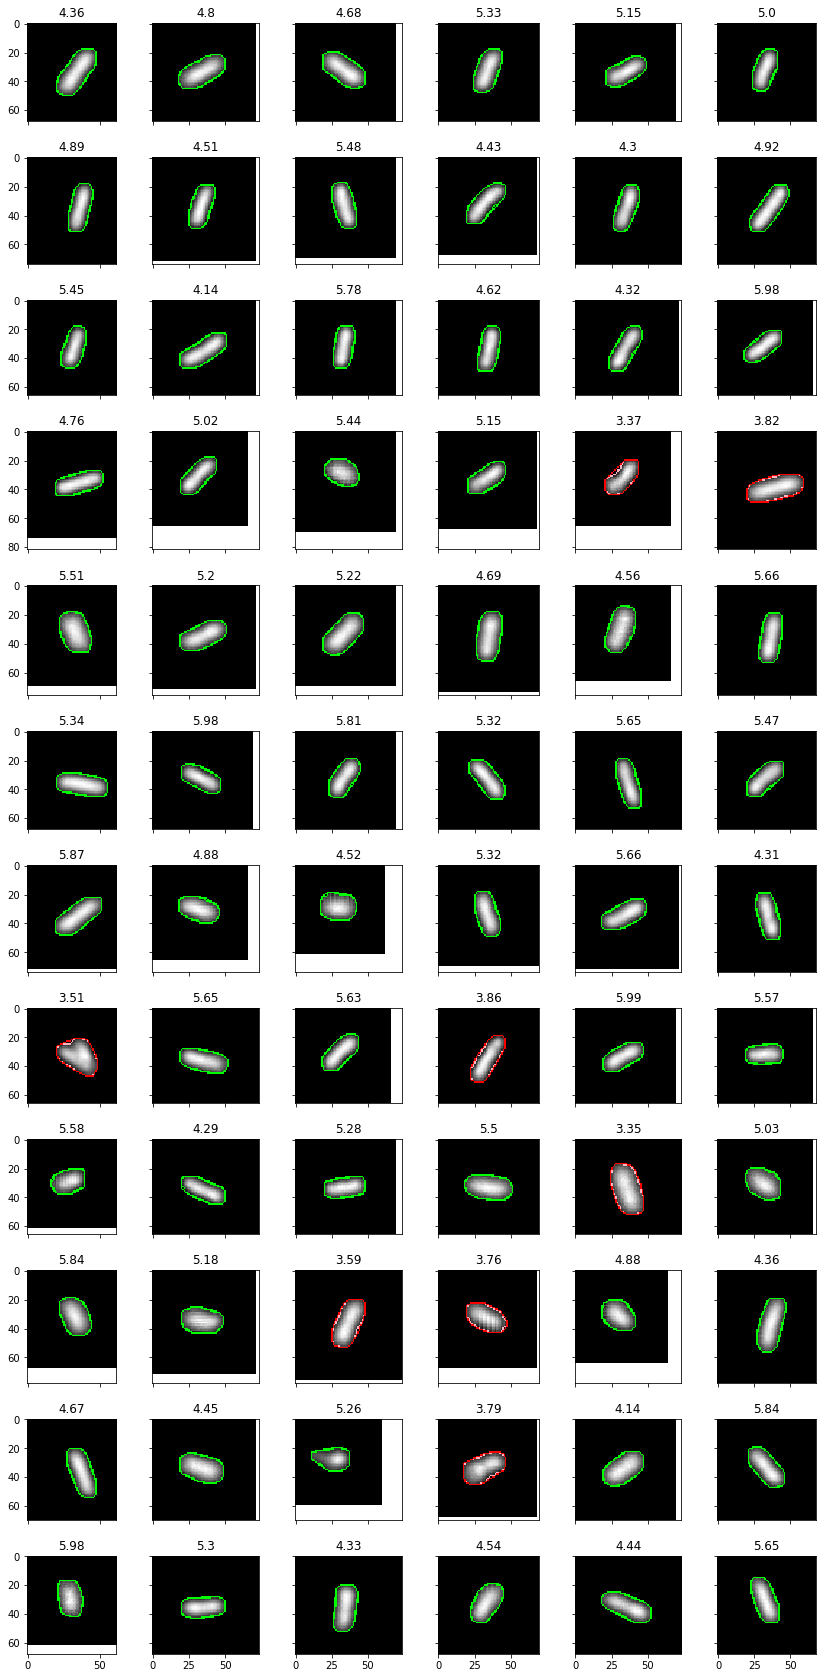

In [14]:
edge_bac_images = []
edge_bac_labels = []
for i in range(len(img_lis)):
    if(contour_counts[i]==1 and scores[i] > 3 and scores[i] < 6):
        edge_bac_images.append(img_lis[i])
        edge_bac_labels.append(scores[i])
               
plot_image_set(edge_bac_images,edge_bac_labels)

## Distribution of scores of images with $contour\_score = 1$

In [15]:
score_dist = []

for i in range(len(img_lis)):
    if(contour_counts[i]==1):
        score_dist.append(scores[i])

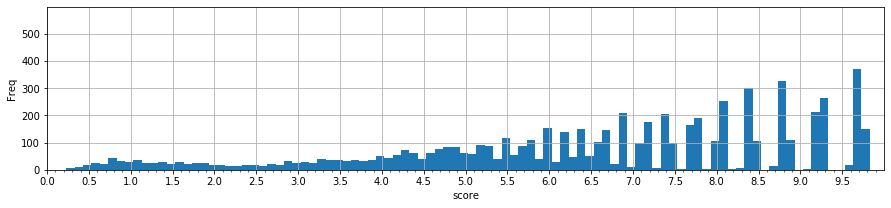

In [16]:
binwidth = 0.1

fig, ax = plt.subplots(figsize=(15,3))


ax.hist(score_dist, bins=np.arange(min(score_dist), max(score_dist) + binwidth, binwidth))

plt.xlabel('score')
plt.ylabel('Freq')
ax.set_xlim(0, 10)


major_ticks = np.arange(0, 10, 0.5 )
minor_ticks = np.arange(0, 10, 0.1)

ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)

plt.grid(True)
plt.show()

Total Bacteria =  17162
Ignored Count  =  1559
  -- multiple  =  589
Proportion Removed =  0.09084022841160704


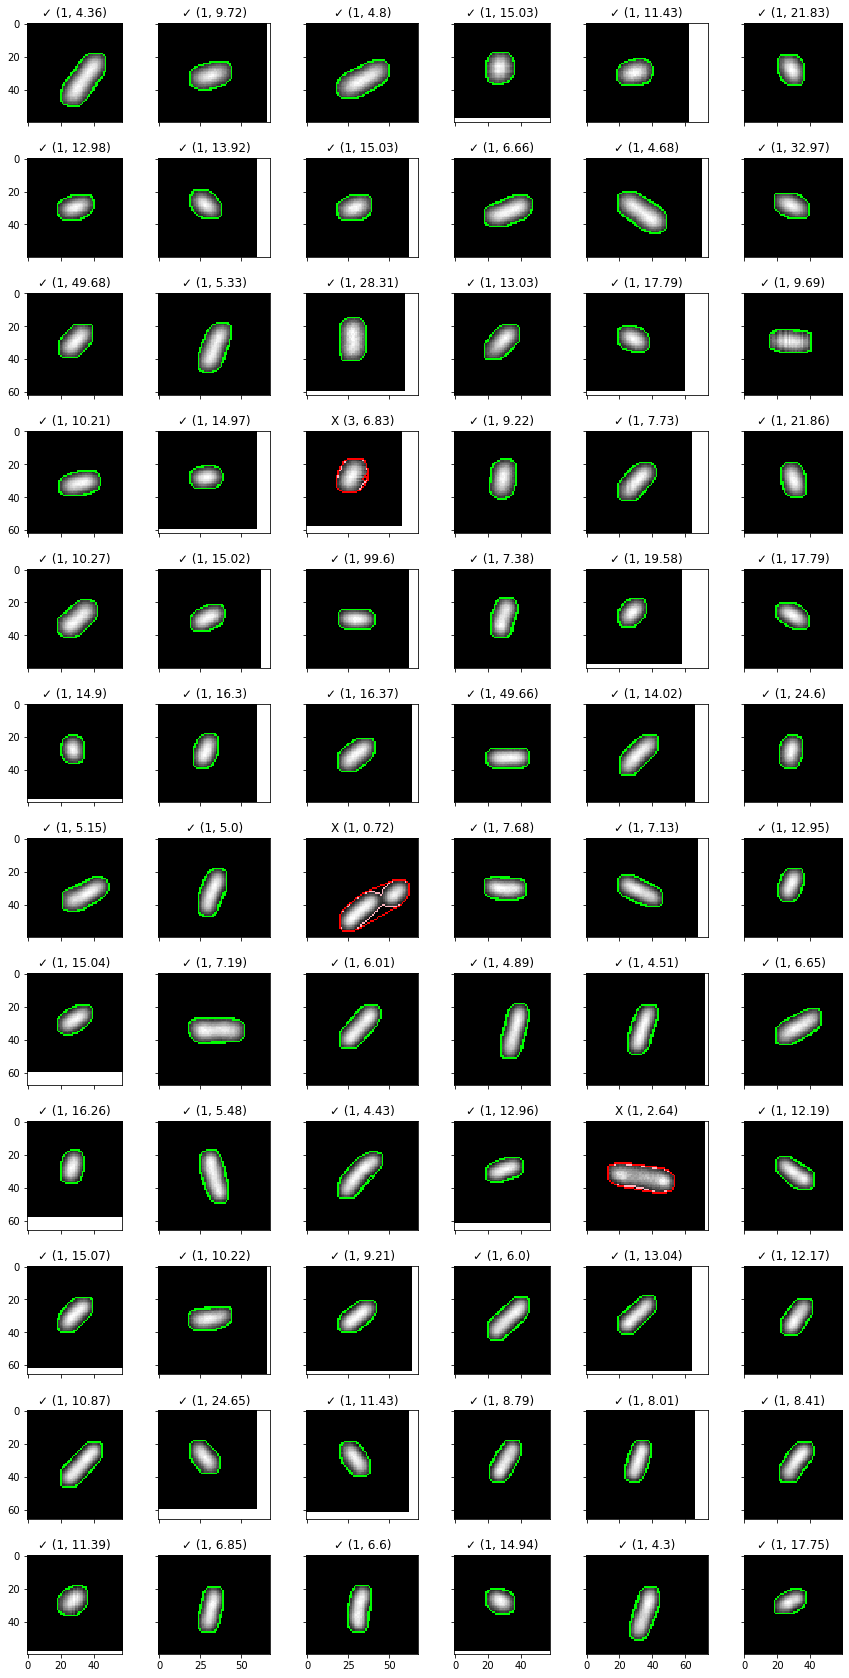

In [17]:
img_lis, contour_count, ignored_bacteria = countIgnoredBacteria(5, len(multiple_bac_images))

plot_image_set(img_lis,contour_count)

# fig.savefig('new_metric.png')